# Entropy

In [4]:
import numpy as np
import matplotlib.pyplot as plt
from qiskit import *
from qiskit.providers.aer.noise import NoiseModel
from qiskit.ignis.verification.tomography import state_tomography_circuits, StateTomographyFitter

provider = IBMQ.load_account()
%matplotlib inline

Entropy is an important concept in information theory, quantifying the amount of uncertainty in an observed state. It is a rich and deep topic; this notebook will cover some high level concepts involving Shannon and von Neumann entropy, and how they may be computed and applied.

### Shannon Entropy

Given a random variable X, learning its value is equivaluent to learning its probability distribution. Its Shannon entropy is a measure of how much information, on average, is gained when its value is learned. It is a function of the distribution, written as:

\begin{equation*}
H(X) = H(p_{1},...,p_{n}) = -\sum_{x}p_{x}log(p_{x})
\end{equation*}

where for our purposes the logarithm is assumed to be base 2, and probability 0 events contribute no entropy. An intuitive justification for the formula follows: given that observing an event with probability p imparts some information $I(p)$, we can assume that learning an independent event with probability q would increase the entropy additively, $I(pq) = I(p) + I(q)$. So, given a process that produces independent outcomes $p_{x}$, the average information gain would be the usual mean of a function, resulting in the equation above. Qiskit has a built in function for this, added below so we can change the default base to 2.

In [8]:
def shannon_entropy(pvec, base=2):
    """
    Compute the Shannon entropy of a probability vector.
    The shannon entropy of a probability vector pv is defined as
    $H(pv) = - \\sum_j pv[j] log_b (pv[j])$ where $0 log_b 0 = 0$.
    Args:
        pvec (array_like): a probability vector.
        base (int): the base of the logarithm
    Returns:
        float: The Shannon entropy H(pvec).
    """
    if base == 2:
        def logfn(x):
            return - x * np.log2(x)
    elif base == np.e:
        def logfn(x):
            return - x * np.log(x)
    else:
        def logfn(x):
            return -x * np.log(x) / np.log(base)

    h = 0.
    for x in pvec:
        if 0 < x < 1:
            h += logfn(x)
    return h


With the formula in mind, more intuition can be gleaned from a simple example. Consider a coin flip. If it is a fair coin, the Shannon entropy evaluates to $-2(0.5log(0.5)) = 1$, which can be interpreted as the coin representing a single bit of uncertain information. If it is a loaded coin, say 25/75 heads/tails, we then have: 

In [15]:
print("The Shannon entropy of a 25/75 coin flip is: ",shannon_entropy([.25,.75]))

The Shannon entropy of a 25/75 coin flip is:  0.8112781244591328


Continuing this trend, we can see that if we had some process always gave the same output, no information can be gained as we already know what will happen. We plot the curve for the binary Shannon entropy below, showing it is maximal when the "coin" is fair, and zero when it is a constant output.

Text(0, 0.5, 'Binary Shannon Entropy')

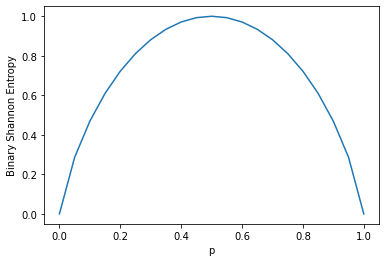

In [40]:
pvals = [i*0.05 for i in range(0,21)]
binaryEntropy = [shannon_entropy([p,1-p]) for p in pvals]
plt.plot(pvals,binaryEntropy)
plt.xlabel('p')
plt.ylabel('Binary Shannon Entropy')

From the above we can see that the entropy is a concave function, with a maximum value limited by the $log(d)$ where d is the number of possible outcomes. These properties can be used to derive a multitude of important results in information theory. This entropy, while a classical quantity, is essential for its quantum counterpart, the von Neumann entropy. 

### Von Neumann Entropy

Now, suppose we're given an arbitrary quantum state $\rho$, which is basically a generalized probability distribution, with eigenvalues $\lambda_{x}$. Then we can define a similar entropy by:

\begin{equation*}
S(\rho) = -tr (\rho log \rho) = -\sum_{x} \lambda_{x} log \lambda_{x}
\end{equation*}

which is known as the von Neumann entropy. From the above it can be seen that for a pure state $\rho = |\psi\rangle\langle\psi|$, as it is idempotent ($\rho  =\rho^{2}$), the diagonalization yields a single eigenvalue of 1. Thus, pure state entropy is simply $log 1 = 0$. Another observation is that for a diagonal density matrix, the second equality is equivalent to the Shannon entropy. This implies that in a fully decohered state, the measurement outcomes are no better than a loaded coin flip, and the state is essentially classical. Pulling it all together, we can come up with the "intuition" that the von Neumann entropy is an measure of the certainty that a given state is quantum. Let's pull in Qiskit's definition of it.

In [45]:
def entropy(state):
    """
    Compute the von-Neumann entropy of a quantum state.
    Args:
        state (array_like): a density matrix or state vector.
    Returns:
        float: The von-Neumann entropy S(rho).
    """
    rho = np.array(state)
    if rho.ndim == 1:
        return 0
    evals = np.maximum(np.linalg.eigvalsh(state), 0.)
#     return shannon_entropy(evals, base=np.e)
    return shannon_entropy(evals, base=2)

An analogous example to what was given for Shannon entropy would be to apply noise to a quantum state. Consider a single qubit initialized to the $|0\rangle$ state in the computational basis, affected by simple depolarizing noise:



\begin{equation*}
E(\rho) = \frac{pI}{2} + (1-p)\rho ,\space\rho = \begin{pmatrix} 1 & 0 \\ 0 & 0 \end{pmatrix}
\end{equation*}

which acts to replace the quantum state with the maximally mixed state with probability p. Say we take a 25/75 split between noisy/pure states, this gives:

In [54]:
def depolarize(rho, p):
   
    rho = p*np.eye(2)/2 + (1-p)*rho
    
    return rho
    
p = 0.25
rho = np.array([[1,0],[0,0]])
noisy_rho = depolarize(rho,p)

print("The von Neumann entropy of a 25/75 depolarizing channel is: ",entropy(noisy_rho))

The von Neumann entropy of a 25/75 depolarizing channel is:  0.5435644431995964


In this case our uncertainty is increased by about 50%. Let's do a sweep to see what the function looks like.

Text(0, 0.5, 'von Neumann Entropy')

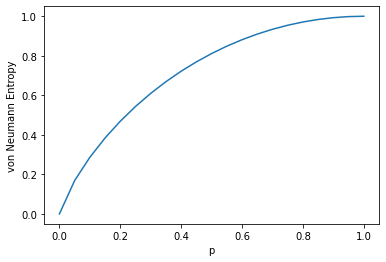

In [56]:
pvals = [i*0.05 for i in range(0,21)]
vonNeumannEntropy = [entropy(depolarize(rho,p)) for p in pvals]
plt.plot(pvals,vonNeumannEntropy)
plt.xlabel('p')
plt.ylabel('von Neumann Entropy')

The function is concave, with a maximum entropy at p = 1, indicating the state is fully decohered into the maximally mixed state at that point. Now we turn to how we might calculate this for a real quantum device. 

### Simulation of a Real Device

Defining a noise model with one of the real backends, we can use the QASM simulator as a rough approximation. We will then use entropy, though overkill as we may just observe fidelity or the output counts, to look at the quality of the initialization for each of the bits on the Vigo device as a simple example.

In [5]:
# Build noise model from backend properties

backend = provider.get_backend('ibmq_vigo')
noise_model = NoiseModel.from_backend(backend)

# Get coupling map from backend
coupling_map = backend.configuration().coupling_map

# Get basis gates from noise model
basis_gates = noise_model.basis_gates

nqubits = len(backend.properties()._qubits)


To get the density matrix, we will use the state tomography functionality of Qiskit, and generate results for each qubit measured.

In [133]:
# Generate quantum circuit experiments

result_matrices = []

for i in range(nqubits):
    circ = QuantumCircuit(nqubits,nqubits)
    
    # Generate the state tomography circuits.
    qst_qc = state_tomography_circuits(circ,circ.qubits[i])
    job = qiskit.execute(qst_qc, Aer.get_backend('qasm_simulator'),shots=8192
                        ,coupling_map=coupling_map
                        ,basis_gates=basis_gates
                        ,noise_model=noise_model
                )
    tomo_qc = StateTomographyFitter(job.result(), qst_qc)
    result_matrices += [tomo_qc.fit()]




Text(0, 0.5, 'von Neumann Entropy')

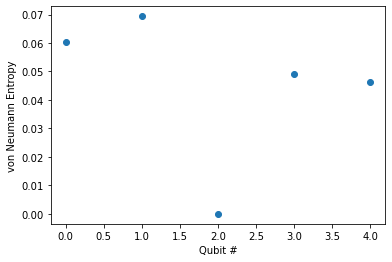

In [134]:
qubits = [i for i in range(nqubits)]
vigoEntropy = [entropy(rho) for rho in result_matrices]
plt.scatter(qubits,vigoEntropy)
plt.xlabel('Qubit #')
plt.ylabel('von Neumann Entropy')

From this qubit 2 seems to have the best initialization. Let's look at which bits fare best at idling.

In [149]:
result_matrices = []

depths = [1,5,10,50,100,500]
results = {}
for q in range(nqubits):
    results[q] = []
    

for i in range(nqubits):
    for depth in depths:
        
        circ = QuantumCircuit(nqubits,nqubits)

        for _ in range(depth): 
            circ.i(i)
            circ.barrier()
  

        # Generate the state tomography circuits.
        qst_qc = state_tomography_circuits(circ,circ.qubits[i])
        job = qiskit.execute(qst_qc, Aer.get_backend('qasm_simulator'),shots=8192
                            ,coupling_map=coupling_map
                            ,basis_gates=basis_gates
                            ,noise_model=noise_model
                    )

        tomo_qc = StateTomographyFitter(job.result(), qst_qc)
        rho = tomo_qc.fit()
        results[i] += [entropy(rho)]



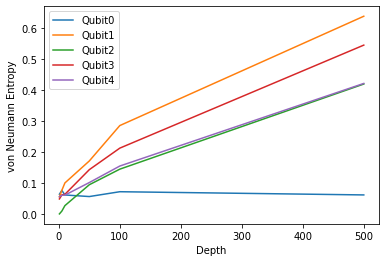

In [150]:
for i in range(nqubits):
    plt.plot(depths,results[i],label='Qubit' + str(i))
plt.xlabel('Depth')
plt.ylabel('von Neumann Entropy')
plt.legend()

From the basic simulation we can see that Qubits 0, 2, and 4 seem the best at idling. We can compare against the calibration data for the T1 relaxation time to see how well the noise model compares to the real device.

In [6]:
T1 = []

for i in range(nqubits):
    T1 += [backend.properties()._qubits[i]['T1'][0]]
           

In [8]:
for i in range(len(T1)):
    print(T1[i])

0.00013017602669790368
7.247889752208142e-05
7.163552399836896e-05
2.709715414292764e-05
0.00012128636374867731


The ordering is off, but it does somewhat catch which qubits are quick to thermally relax.

We've gone through a brief overview of what classical and quantum entropies are. By itself, entropy seems a roundabout way to check performance of quantum systems at the circuit level of abstraction as we've done here. However, entropy is used in the calculation of important properties in quantum information resource theories, such as those of coherence and entanglement, as well as in coding/compression and communication theory. 

# References

[1] M. Nielsen, I. Chuang. Quantum Computation and Quantum Information